In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from random import random
import matplotlib.colors as colors
from sklearn.metrics import mean_squared_error
from math import sqrt
import seaborn as sns

# Genetic Algorithm Functions

In [2]:
def get_individual():
    """
    #'Create a member (candidate solution) of the population, 
    # ie '000111001110100101000001'
    """
    return [ ''.join(str(x) for x in np.random.choice(2, 24)) ]

In [3]:
get_individual()

['010010001110001110111001']

In [4]:
def get_population(count=1000):
    """
    Create a population (collection of individuals/solutions).
    count: the number of individuals in the population
    """
    return [ get_individual() for x in xrange(count) ]

In [5]:
p = get_population(count=10)
p

[['001000111111010101101010'],
 ['101101011110111000001101'],
 ['111101010111000010001010'],
 ['001011001001111011000011'],
 ['110111111100000001011011'],
 ['111101110010110110011001'],
 ['011001110001001111001111'],
 ['110011110001010110100101'],
 ['101000110101110100000010'],
 ['010100010001110100000101']]

In [6]:
def fitness(individual):
    """
    Determine the fitness of an individual/solution. Closer to target (51,255,255) the better.
    individual: the individual to evaluate
    """
    R = int(individual[:8],2)
    G = int(individual[8:16], 2)
    B = int(individual[16:], 2)
    
    score = sqrt(mean_squared_error([R,G,B],target))
    
    return score

In [7]:
# Cyan (51,255,255) 
target = (51,255,255)  
# in binary is 00110011 11111111 11111111 

In [8]:
# Comapre each individuals fitness
fitness('111011110000100011000000')

182.86789402917796

In [9]:
fitness('001011111111101011111111')

3.696845502136472

In [10]:
def population_score(population):
    """
    Find average fitness for a population.
    pop: population, collection of individuals/solutions, as list.
    target: satisfactory level of fitness.
    """ 
    pop_scores = [fitness(x[0]) for x in population]
    
    return np.mean(pop_scores)

In [11]:
# Average of fitness scores
population_score(p)

147.73930845324682

### Putting it all together:

In [12]:
def evolve_all(population=get_population(), survivors=0.6, mutation_rate=0.01, random_selection=0.05):    
    """
    Evolve a population of individuals/solutions until a target fitness is met, or a max number of
        iterations is reached. .
    max_gens: max num of generations to test.
    survivors: fraction of individuals that will pass their genes to the next generation
    random_selection: probability of new individuals entering the population.
    mutation: probability of mutation.
    """
    
    # Rank the fitness of each individual in the current generation.
    # The smaller the score (RMSE) the better.
    rank = [ (fitness(x[0]), x ) for x in population ]

    print 'Individuals rank:\n  Fitness          Individual'
    for ind in sorted(rank):
        print '%f  -- %s' % (ind[0], ind[1][0])
        
    rank = [ x[1] for x in sorted(rank)]
    
    # Select the top fit individuals to compose the next generation
    num_survivors = int(len(rank)*survivors)
    parents = rank[:num_survivors]
    
    # Randomnly keep other individuals in the pool, for the sake of diversity
    for individual in rank[num_survivors:]:
        if random_selection > random():
            parents.append(individual)
            
    # Mutate some of the parental solutions
    # Each bit has a 100 * mutation_rate % chance to flip
    for p_idx in range(0,len(parents)):
        genes = list(parents[p_idx][0])
        for g_idx in range(0,len(genes)):
            if mutation_rate > random():
                print 'Mutation!!'
                genes[g_idx] = str(1 - int(genes[g_idx]))
        parents[p_idx] = [''.join(genes)]
        
    # Crossover parental solutions to create new ones
    parents_length = len(parents)
    open_spots = len(population) - parents_length
    new_solutions = []
    
    while len(new_solutions) < open_spots:
        parent_1 = np.random.randint(0, parents_length-1)
        parent_2 = np.random.randint(0, parents_length-1)
        if parent_1 != parent_2:
            parent_1 = parents[parent_1]
            parent_2 = parents[parent_2]
            # Randomly set crossover spot
            split = np.random.randint(1,24)
            child = parent_1[:split] + parent_2[split:]
            new_solutions.append(child)
            
    # New population composed by survivor solutions+ new solutions
    parents.extend(new_solutions)
    
    return parents

# Plotting Functions

In [13]:
def plot_fitness(fitness_history):
    """
    Plot the average fitness across generations
    """
    generations = range(0,len(fitness_history))
    plt.plot(generations, fitness_history, label="Fitness")
    plt.plot(generations, [tolerance]*len(generations), color='r', linestyle='--',label=("Target")) 
    plt.xlim([0,len(generations)])
    plt.ylim([0,max(fitness_history)+20])
    plt.title('Fitness per generation (RMSE)')
    plt.xlabel('Generations')
    plt.ylabel('Fitness')
    plt.legend()

In [14]:
def rgb_to_hex(rgb_tuple):
    """
    Convert RGB to Hex color code for plotting
    """
    return colors.rgb2hex([ 1.0 * x /255 for x in rgb_tuple])


def bin_to_hex(individual):
    """
    Convert a binary string (len 24) to RGB
    """
    R = int(individual[:8],2)
    G = int(individual[8:16], 2)
    B = int(individual[16:], 2)
    
    hex_col = colors.rgb2hex([ 1.0 * x /255 for x in (R,G,B)])
    
    return hex_col

In [15]:
# Magenta
bin_to_hex('111111110000000011111111')

u'#ff00ff'

In [16]:
rgb_to_hex((255,0,255))

u'#ff00ff'

In [17]:
def plot_evolution(all_Ps, surv, mut_rate):
    """
    Plot a colored progression of the population towards target fitness
    """
    plt.figure(figsize=(18,5))
    for i,p in enumerate(all_Ps):
        cols = map(lambda x: bin_to_hex(x[0]), p[0])   
        # All populations stored in a list of lists
        plt.scatter([i]*len(p[0]), range(0,len(p[0])),marker='s', s=400, color=cols)
    plt.title('Evolution of algorithm with %2.0f/100 survival and %2.2f mutation rate per bit' % (surv*100,mut_rate))
    plt.xlabel('Generation')
    plt.ylabel('Individuals')
    plt.xlim([-1,len(all_Ps)])
    plt.ylim([-1,len(p[0])])
    plt.show()

# Give it a try...

In [18]:
target          = [51,255,255]  # Cyan
tolerance       = 30            # Aimed fitness value
max_generations = 1000          # Max iterations
n_individuals   = 100           # Number of solutions
frac_survivors  = 0.8           # Fraction of survivors per generation
mut_rate        = 0.02          # Change of mutation per gene (bit)

# Time zero space of solutions
P = get_population(count=n_individuals)    
all_Ps = [[P]]

# Track of fitness over time
fitness_history = [population_score(population=P)]   # Fitness of the populaiton (average)

# Go...
for generation in range(1,max_generations+1):
    # Evolve them:
    P = evolve_all(population=P,survivors=frac_survivors, mutation_rate=mut_rate, random_selection=0.05)
    
    # Score population fitness and keep populations in record
    fitness_history.append(population_score(population=P))
    all_Ps.append([P])
    
    # Update to screen
    print '\nGeneration: %d, Population fitness: %f' % (generation, fitness_history[-1])
    
    # Terminate if target is met
    if fitness_history[-1] < tolerance:
        break

Individuals rank:
  Fitness          Individual
16.872068  -- 010011001111000011111101
18.618987  -- 001100111110001111101111
37.336309  -- 000001001101100111101000
42.497059  -- 010010111111011010111010
49.078169  -- 001100101011101111001100
52.694086  -- 000000001100100011001011
53.419722  -- 010010111101000010110011
60.541996  -- 010010011001111111011011
64.316924  -- 100100001110011011000111
65.176683  -- 011001011010011111001101
68.883960  -- 010100001000110011110010
72.938330  -- 100100011100110110111011
72.940615  -- 010010111011011110011010
73.948180  -- 001100111000000111101000
74.755156  -- 001001101100001110001101
75.139870  -- 011011001000101011111111
76.526684  -- 011000011110110110000100
81.527092  -- 001101111110110101110011
84.194220  -- 011100111000101011000100
87.103387  -- 001100101000100110100001
88.124911  -- 000010001001010010011011
88.223202  -- 011101001100011010000001
88.253423  -- 000101101110110101101010
88.675438  -- 101100101110000110101110
91.201243  -- 00

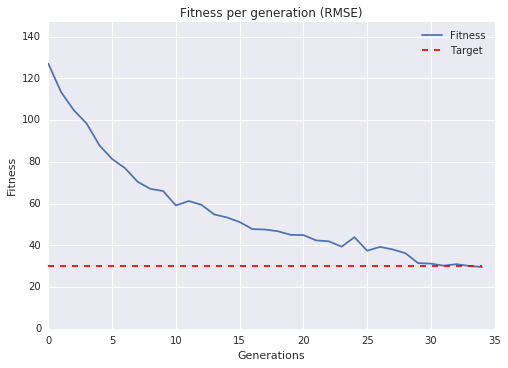

In [19]:
plot_fitness(fitness_history)

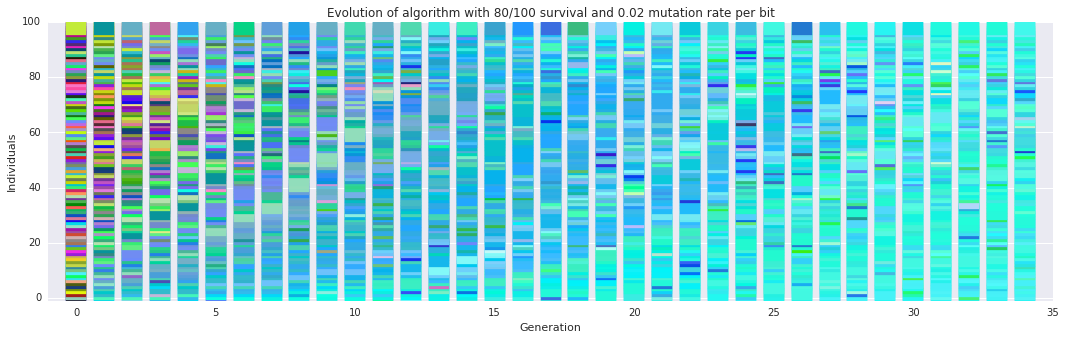

In [20]:
plot_evolution(all_Ps, frac_survivors, mut_rate)